In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.onnx
from torchvision import datasets
from torch.utils.data import DataLoader
import os
import time
import copy
import re

# Reference : Perceptual Losses for Real-Time Style Transfer and Super-Resolution (https://arxiv.org/pdf/1603.08155.pdf)

### Initial Convolution Layers:

These layers extract low-level features from the input image, helping the network learn basic patterns and structures. The gradual reduction in spatial dimensions and increase in channels enable the network to capture hierarchical features.

### Residual Layers:

Residual blocks facilitate the learning of residual mappings, allowing the network to capture more complex and abstract features. The skip connections in residual blocks help in mitigating the vanishing gradient problem and preserving important information during training.

### Upsampling Layers:

Upsampling layers are essential for increasing the spatial dimensions of the feature maps, allowing the network to generate a high-resolution output. Combining upsampling with convolution helps prevent checkerboard artifacts that may arise from simple upsampling techniques.

### The overall architecture :

Initial convolutions capture basic features, residual blocks capture complex patterns, and upsampling layers restore spatial dimensions. The combination of these components enables the network to learn and transfer artistic styles effectively.


In [2]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)

        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock"""

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out
    
class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

### Pre-Trained VGG
Sliced to get the relevant feature maps, used for calculation of Perceptual Loss
Perceptual loss involves computing the difference between the feature representations of the generated image and the reference image using the sliced VGG model. This loss metric captures perceptual similarity and encourages the generated image to have similar features to the reference image.



In [6]:
from collections import namedtuple

import torch
from torchvision import models


class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [17]:
from PIL import Image

def load_image(filename, size=None, scale=None):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.Resampling.LANCZOS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.Resampling.LANCZOS)
    return img

def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

# Training, Validation & Test Loops

In [8]:
def train():
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transformer = TransformerNet().to(device)
    vgg = Vgg16(requires_grad=False).to(device)
    
    optimizer = torch.optim.Adam(transformer.parameters(), lr = lr)
    mse_loss = torch.nn.MSELoss()
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = load_image(style_image)
    style = style_transform(style)
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    
    master_dataset = datasets.ImageFolder(dataset, transform)
    n = len(master_dataset)
    n_train = int(n * 0.8)  # 80% of data for training
    n_val = int(n * 0.1)  # 10% of data for validation
    n_test = n - n_train - n_val  # 10% of data for testing

    # Create train, validation and test datasets
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(master_dataset, (n_train, n_val, n_test))

    # Create data loaders for train, validation and test datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    features_style = vgg(normalize_batch(style))
    gram_style = [gram_matrix(y) for y in features_style]
    
    
    best_val_loss = float('inf')
    final_train_loss = None
    final_val_loss = None
    final_test_loss = None

    #Training Loop
    
    for e in range(epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = normalize_batch(y)
            x = normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)
            
            #Perceptual Loss
            content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)
            
            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)
            # Uncomment if want to store the Checkpoints as per the log checkpoint_interval.
#             if checkpoint_model_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
#                 transformer.eval().cpu()
#                 ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
#                 ckpt_model_path = os.path.join(checkpoint_model_dir, ckpt_model_filename)
#                 torch.save(transformer.state_dict(), ckpt_model_path)
#                 transformer.to(device).train()
                
    
        # Validation Loop
        transformer.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in val_loader:
                n_batch = len(x)
                count += n_batch
                
                x = x.to(device)
                y = transformer(x)
                y = normalize_batch(y)
                x = normalize_batch(x)
                features_y = vgg(y)
                features_x = vgg(x)
                content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)
                style_loss = 0.
                for ft_y, gm_s in zip(features_y, gram_style):
                    gm_y = gram_matrix(ft_y)
                    style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
                style_loss *= style_weight

                val_loss += content_loss.item() + style_loss.item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(transformer.state_dict())
            ckpt_model_path = os.path.join(checkpoint_model_dir, 'best_model.pth')
            torch.save(transformer.state_dict(), ckpt_model_path)
    
    transformer.load_state_dict(best_model_wts)
    final_train_loss = (agg_content_loss + agg_style_loss) / (batch_id + 1)

    # Test Loop
    transformer.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            n_batch = len(x)
            count += n_batch
            x = x.to(device)
            y = transformer(x)
            y = normalize_batch(y)
            x = normalize_batch(x)
            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)
            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= style_weight

            test_loss += content_loss.item() + style_loss.item()
        final_test_loss = test_loss

    # Print final losses
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {best_val_loss}")
    print(f"Final Test Loss: {final_test_loss}")
    
    transformer.eval().cpu()
    save_model_filename = "epoch_" + str(epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
        content_weight) + "_" + str(style_weight) + ".model"
    save_model_path = os.path.join(save_model_dir, save_model_filename)
    torch.save(transformer.state_dict(), save_model_path)
    print("\nDone, trained model saved at", save_model_path)

### Dataset Used - Flickr Image Dataset 
It is a small dataset consisting of 8K images, as training on more images require a lot of time and compute, which we were short on.

Change the dataset = "/kaggle/input/flickr8k" - to whatever dataset you want to use.
The dataset directory should have another folder with images in it.

### content_weight and style_weight :
These are the parameters which control the weight of the content and the style in the final transformed image, can play around with these parameters to get results suited to your liking.

### Output Location and best_model.pth
The best model according to the validation set, evaluated on the total_loss which comprises of style_loss and content_loss, is stored in the output_dir, the location of this you can change by changing checkpoint_model_dir.

### style_image : 
Path to the style image, for each image we need to train the model again.

For Each Style Image we need to train the model

In [9]:
lr = 1e-3       # Learning Rate
style_image  = "/kaggle/input/wavess/waves.jpg"    # Style Image 
batch_size = 4
image_size = 256
epochs = 5
content_weight = 1e+5                            
style_weight = 4e+10
checkpoint_model_dir = "./output_dir"
checkpoint_interval = 500    
dataset = "/kaggle/input/flickr8k"   # DataSet
save_model_dir = "./models"
log_interval = 30

checkpoint_model_dir = "./output_dir"
save_model_dir = "./models"
from pathlib import Path
Path(save_model_dir).mkdir(parents=True, exist_ok=True)
Path(checkpoint_model_dir).mkdir(parents=True, exist_ok=True)
train()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 262MB/s]  


Mon Nov 27 16:46:40 2023	Epoch 1:	[120/6472]	content: 648156.503125	style: 15137749.000000	total: 15785905.503125
Mon Nov 27 16:46:45 2023	Epoch 1:	[240/6472]	content: 713297.025521	style: 12141310.291667	total: 12854607.317187
Mon Nov 27 16:46:50 2023	Epoch 1:	[360/6472]	content: 767198.355903	style: 10166279.650000	total: 10933478.005903
Mon Nov 27 16:46:56 2023	Epoch 1:	[480/6472]	content: 793076.373698	style: 8777284.802083	total: 9570361.175781
Mon Nov 27 16:47:01 2023	Epoch 1:	[600/6472]	content: 814955.984792	style: 7705529.243333	total: 8520485.228125
Mon Nov 27 16:47:07 2023	Epoch 1:	[720/6472]	content: 834936.843924	style: 6847166.180556	total: 7682103.024479
Mon Nov 27 16:47:12 2023	Epoch 1:	[840/6472]	content: 849212.573661	style: 6163986.804762	total: 7013199.378423
Mon Nov 27 16:47:18 2023	Epoch 1:	[960/6472]	content: 863730.342318	style: 5602958.061458	total: 6466688.403776
Mon Nov 27 16:47:23 2023	Epoch 1:	[1080/6472]	content: 871875.672106	style: 5138511.381944	total: 

# Evaluation 

Model Performance can be evaluated by comparing the Training, Validation and Test Losses.
Difference between the Validation and Test Losses, helps us to evaluate whether the model is able to generalise for unseen images.

In [15]:
def stylize(content_image, content_scale, output_image, model):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content_image = load_image(content_image, scale=content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        style_model = TransformerNet()
        state_dict = torch.load(model)
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.load_state_dict(state_dict)
        style_model.to(device)
        style_model.eval()
        output = style_model(content_image).cpu()
    
    save_image(output_image, output[0])

# Style Adaptation

content_image - The image you want to transfer the style to

output_image - Path where you want to save the output image

model_path - Path to the Best Model Weights


In [18]:
content_image = "/kaggle/input/trysss/uzbekistan-dome.jpg"
content_scale = 2
output_image = "out.jpg"
model_path = "/kaggle/working/output_dir/best_model.pth"
stylize(content_image, content_scale, output_image, model_path)

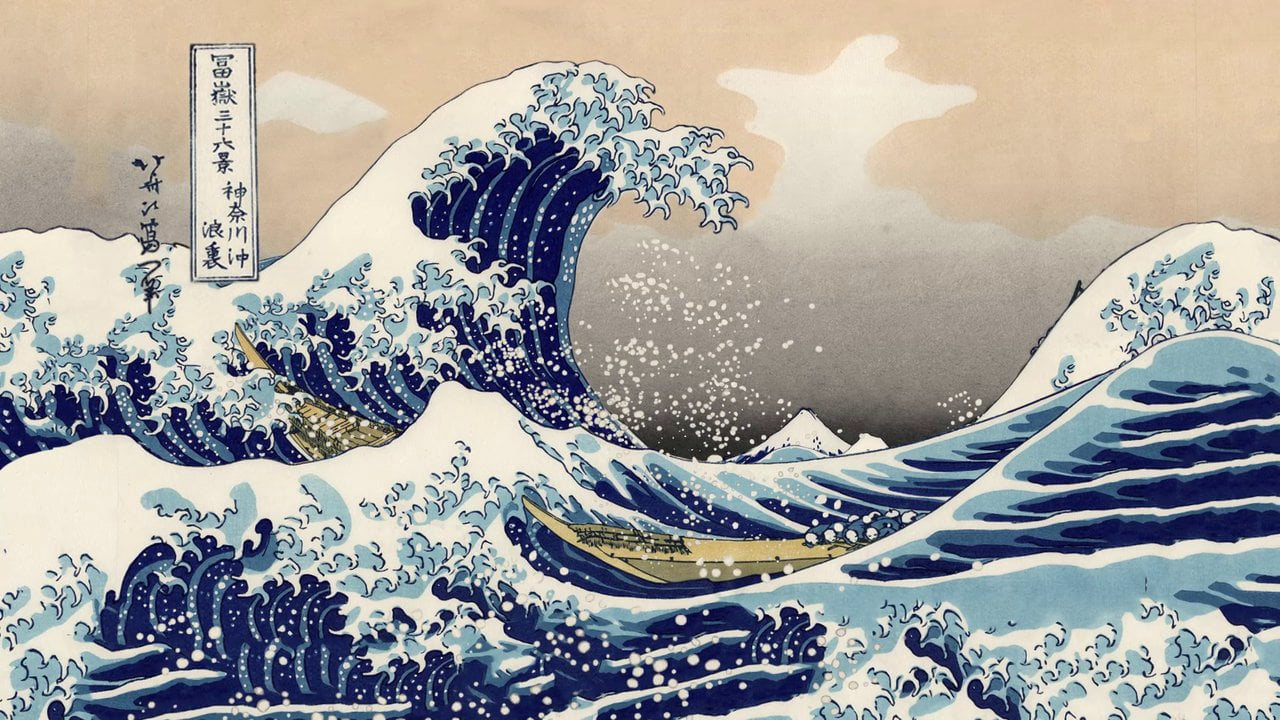

In [19]:
pil_im = Image.open('/kaggle/input/wavess/waves.jpg')
# Style Image
display(pil_im)

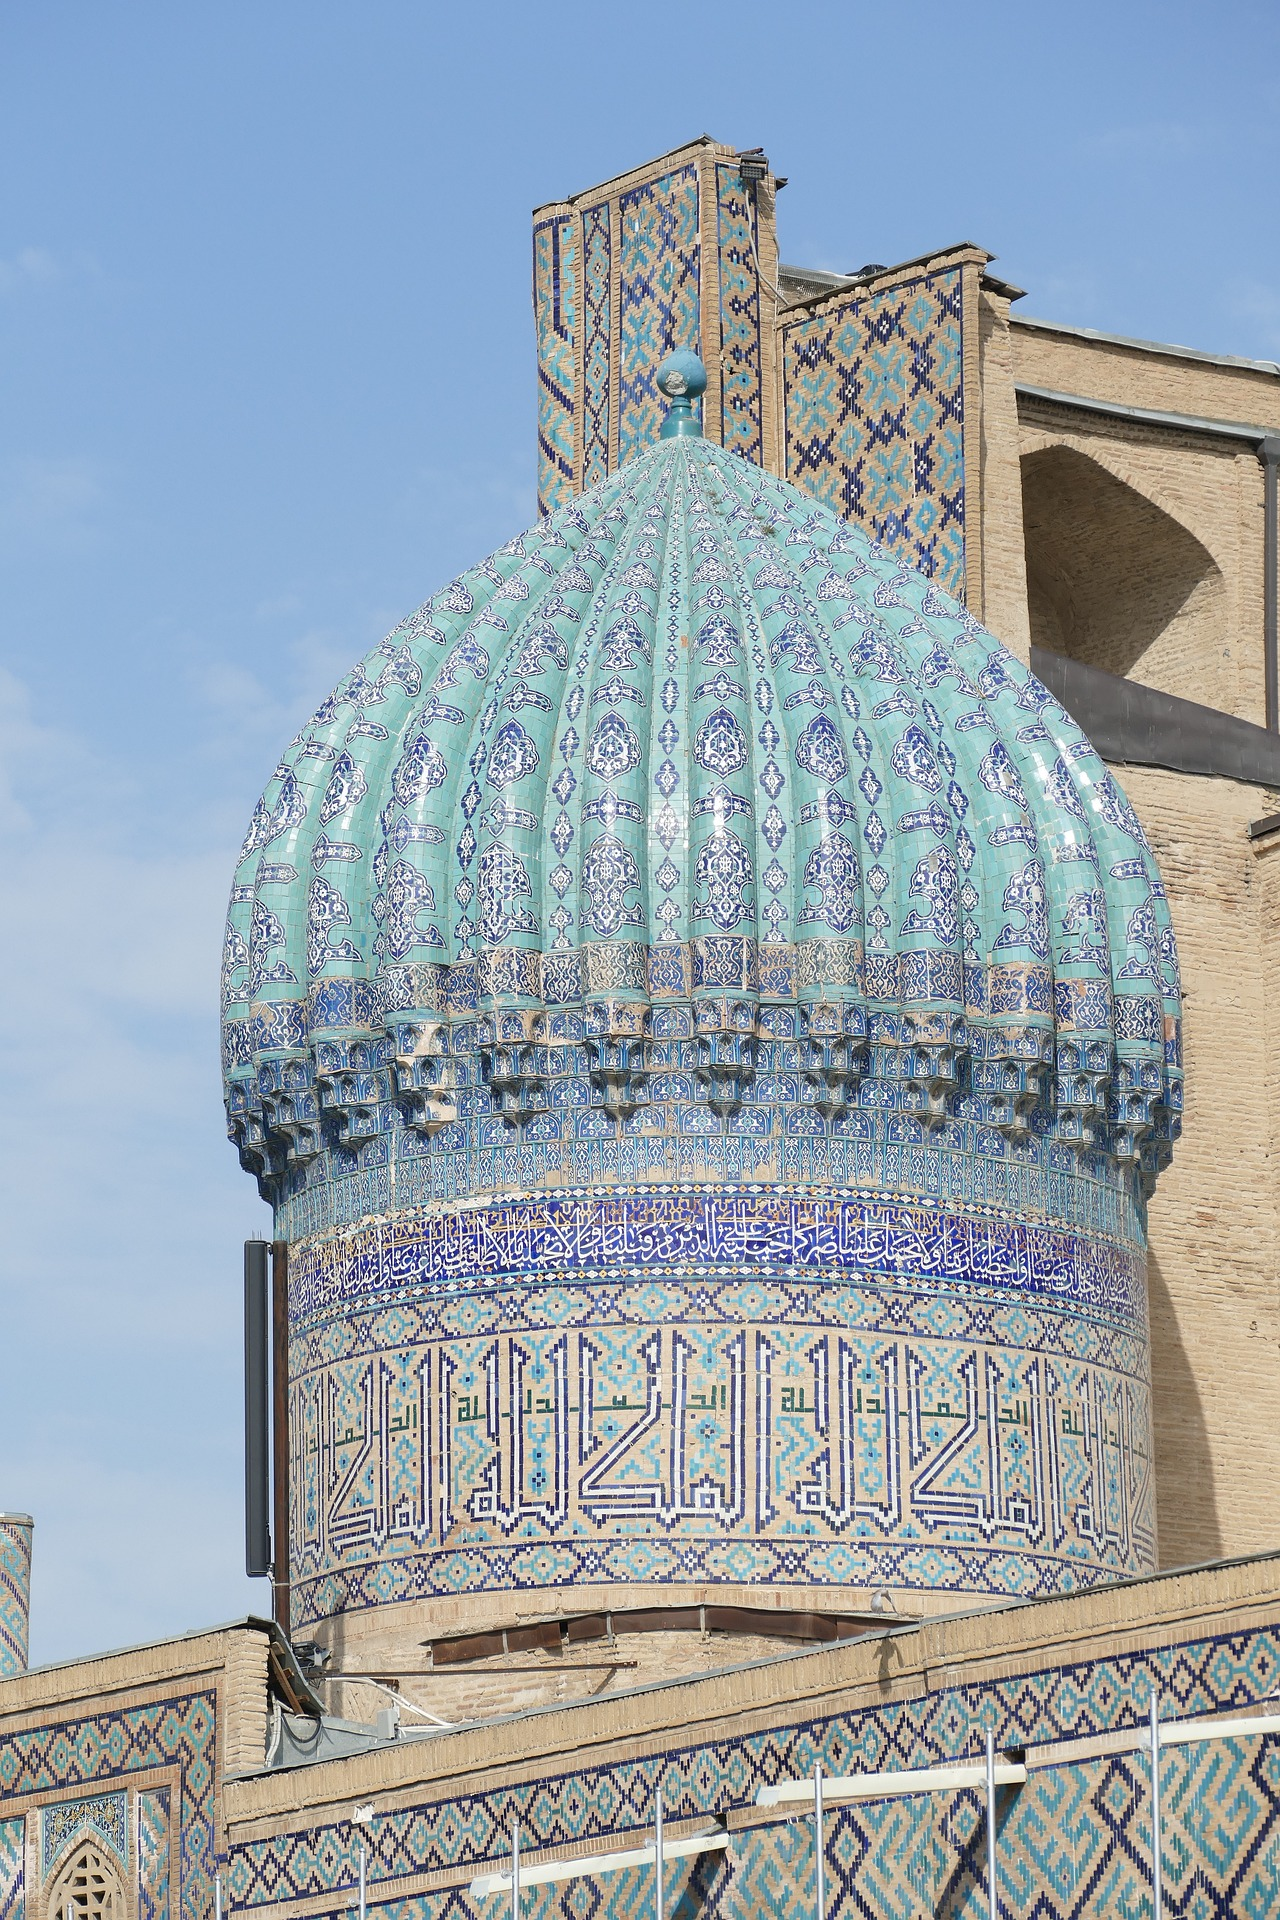

In [20]:
pil_im = Image.open('/kaggle/input/trysss/uzbekistan-dome.jpg')
# Content Image
display(pil_im)

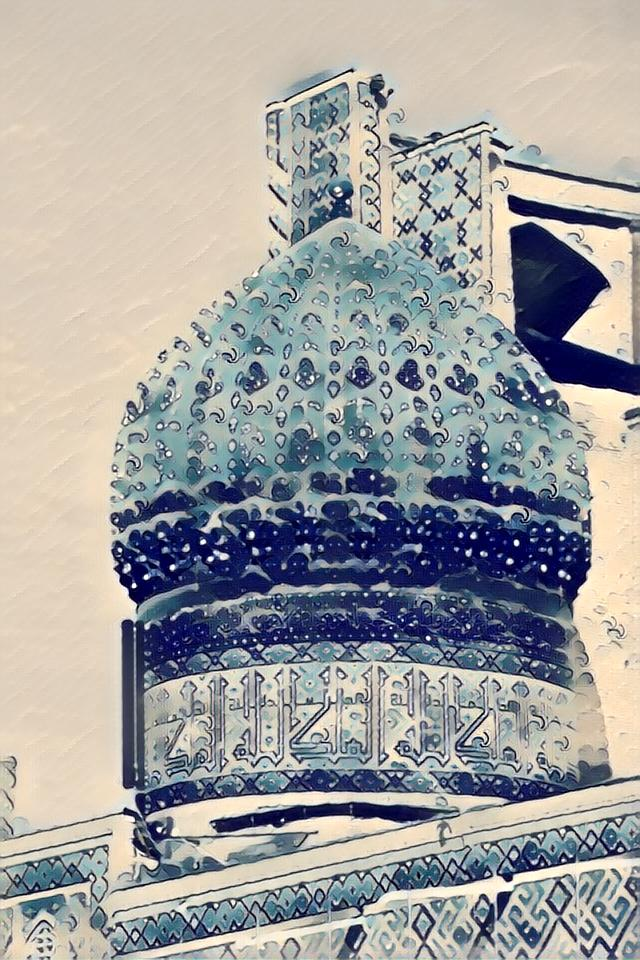

In [21]:
pil_im = Image.open('/kaggle/working/out.jpg')
# Styled Content Image
display(pil_im)

Evaluation Criterion:

Perceptual Loss : 
This involves using pre-trained deep neural networks (We used VGG here) to compute a perceptual loss between the generated and target images. The idea is that the model should not only reproduce pixel-level similarities but also capture higher-level perceptual features.

Gram Matrix for Style Loss: 
It represents the correlations between the different filter responses in a given layer of a neural network.
By calculating the Gram matrix for the style image and the generated image, we can evaluate the similarity between these Gram matrices. A smaller difference indicates that the style is well-transferred.

The loss function we are minimising in the model consists of weighted sum of perceptual loss and gram matrix loss i.e. style loss.


# Conclusion 

### Limitations :
Lack of Spatial Structure Preservation: While the method does a good job at preserving stylistic features from the target image, it does not always preserve its spatial structure. This might limit the method's performance on tasks where preserving spatial structure is crucial

### Potential Improvements :
Improved Loss Functions: The perceptual loss functions used in this approach can potentially be improved or replaced with other types of loss functions that are better at preserving spatial structure or reducing artifacts in the transformed images

Use of Different Pretrained Networks: The performance of this method might be improved by using different pretrained networks for extracting high-level features, depending on the specific image transformation task at hand [Source
